In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
import pandas as pd
import numpy as np

### Helper Functions

In [5]:
def normalize_zscores(row):
    zscores = np.array(row)
    norm_zscores = (zscores - np.nanmean(zscores)) / np.nanstd(zscores)
    return norm_zscores

### Data Intake

In [6]:
df = pd.read_csv("IAPM_data.csv")
df["#NAME?"] = pd.to_datetime(df["#NAME?"], dayfirst=True)
df.rename(columns={"#NAME?":"Datetime"}, inplace=True)
df["Datetime"] = df["Datetime"].apply(lambda x: x.date())
df.set_index("Datetime", inplace=True)
df.drop([col for col in df.columns if "ERROR" in col], axis=1, inplace=True)


In [7]:
tickers = []
for col in df.columns:
    try:
        tickers.append(col.split(" - ")[0])
    except:
        pass

tickers = list(set(tickers))

In [8]:
tickers_to_remove = ["ONE 97 COMMUNICATIONS"]
tickers = [ticker for ticker in tickers if ticker not in tickers_to_remove]

In [9]:
data = df[tickers]

<Axes: >

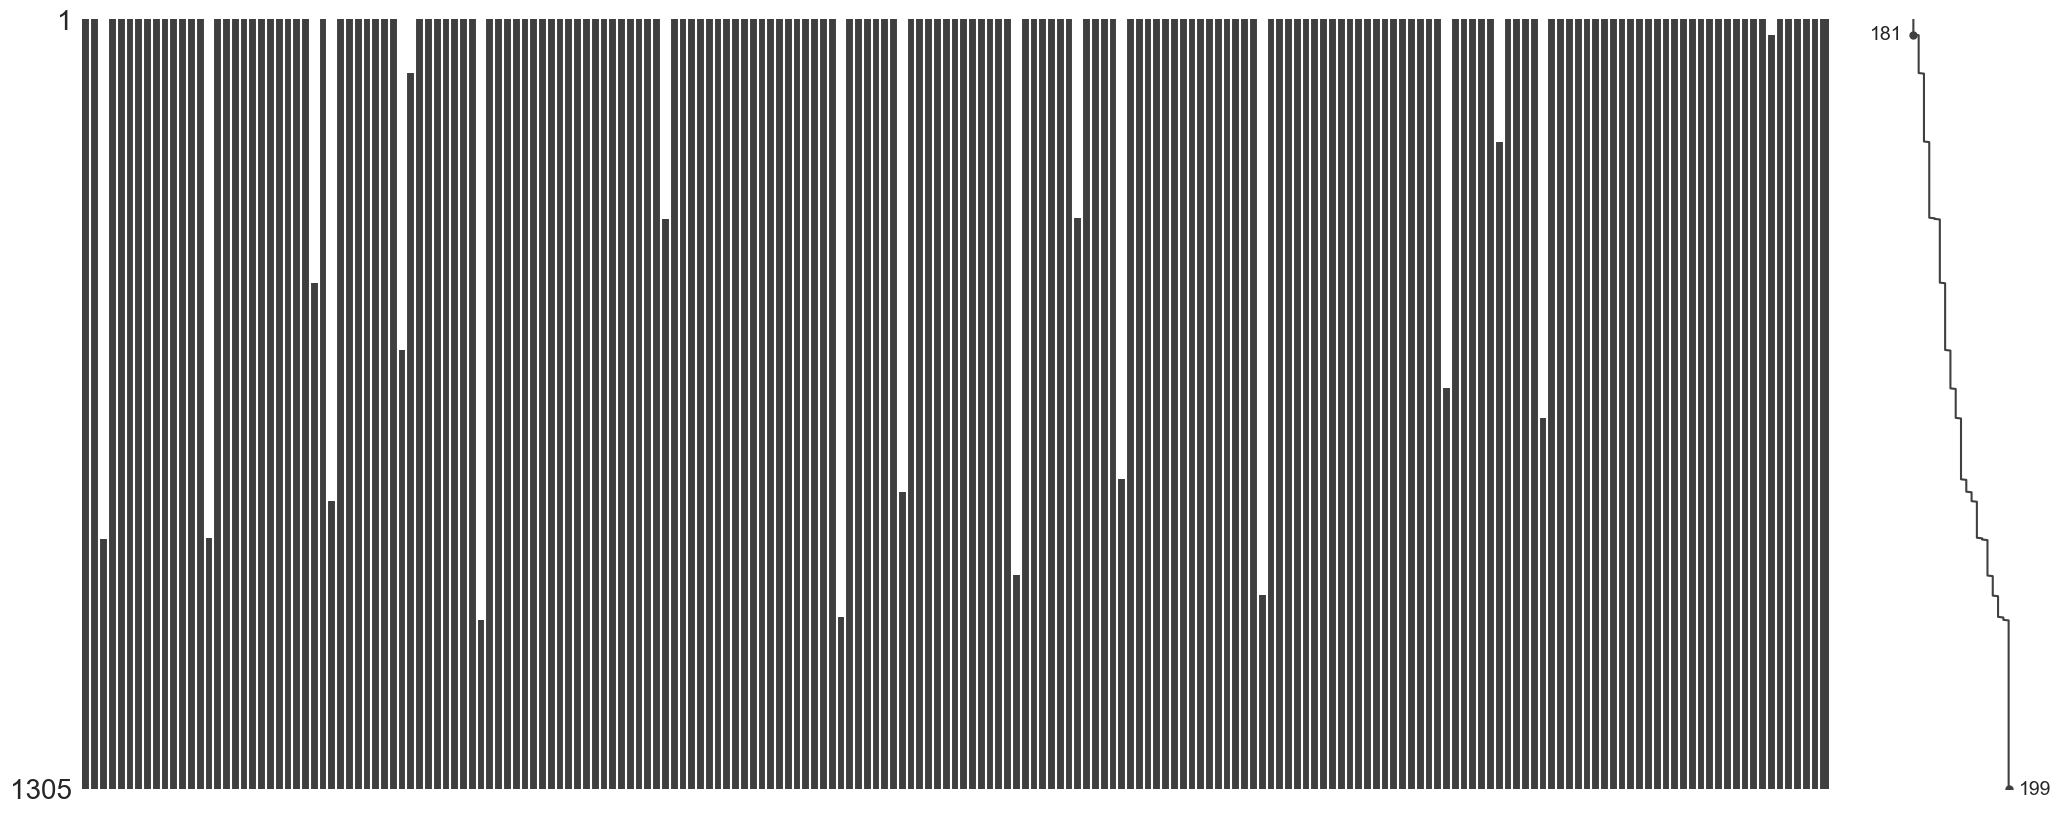

In [10]:
import missingno as msno
msno.matrix(data)

Factor #1: SIZE: zscore(1/marketcap(m-1))

In [11]:
for ticker in tickers:
    data = pd.concat([data, 1/df[[f"{ticker} - MARKET VALUE"]].shift(30).rename(columns={f"{ticker} - MARKET VALUE":f"{ticker}_SIZE"})], axis=1)

data[[col for col in data.columns if "_SIZE" in col]] = data[[col for col in data.columns if "_SIZE" in col]].apply(normalize_zscores, axis=1, result_type='broadcast')



Factor #2: VAL_ac: zscore(BookValue(m-3)/P(m-1))

In [12]:
for ticker in tickers:
    ratio = pd.DataFrame()
    ratio[f"{ticker}_VAL_ac"] = df[f"{ticker} - BOOK VALUE PER SHARE"].fillna(method="ffill").shift(3*30)/df[ticker].shift(30)
    data = pd.concat([data, ratio], axis=1)

data[[col for col in data.columns if "_VAL_ac" in col]] = data[[col for col in data.columns if "_VAL_ac" in col]].apply(normalize_zscores, axis=1, result_type='broadcast')

Factor #3: MOM_ac: Price Momentum (12 months skip current month)

In [13]:
for ticker in tickers:
    data[f"{ticker}_MOM_ac"] = data[ticker].shift(30)/data[ticker].shift(365) - 1

data[[col for col in data.columns if "_MOM_ac" in col]] = data[[col for col in data.columns if "_MOM_ac" in col]].apply(normalize_zscores, axis=1, result_type='broadcast')

Factor #4: LOVOL: 12 month daily price log return volatility from M-1 to M-13

In [14]:
for ticker in tickers:
    data[f"{ticker}_LOVOL"] = 1/np.log(data[ticker]/data[ticker].shift(365)).rolling(13*30).apply(lambda x: x[:-30].std())

data[[col for col in data.columns if "_LOVOL" in col]] = data[[col for col in data.columns if "_LOVOL" in col]].apply(normalize_zscores, axis=1, result_type='broadcast')

Factor #5: BETA

In [15]:
market_data = pd.read_csv("NIFTY_200.csv")
market_data["Datetime"] = pd.to_datetime(market_data["Datetime"])
market_data["Datetime"] = market_data["Datetime"].apply(lambda x: x.date())
market_data =  market_data.set_index("Datetime")[["Close"]].rename(columns={"Close":"NIFTY_200"})
data = pd.concat([data, market_data], axis=1).sort_index()

In [16]:
for ticker in tickers:
    data[f"{ticker}_BETA"] = np.nan
    for i in range(364, len(data)):
        dd = data[[ticker, "NIFTY_200"]].iloc[i-365+1:i+1].dropna()
        tickerdata = dd[ticker]
        indexdata = dd["NIFTY_200"]
        cov = np.cov(tickerdata, indexdata)
        beta = cov[0,1]/cov[1,1]
        data.loc[data.index[i], f"{ticker}_BETA"] = beta

data[[col for col in data.columns if "_BETA" in col]] = data[[col for col in data.columns if "_BETA" in col]].apply(normalize_zscores, axis=1, result_type='broadcast')

In [27]:
data[data.index>pd.to_datetime("2022-01-01").date()]

,BAJAJ AUTO,BAJAJ HOLDINGS & INVS.,PB FINTECH,CONTAINER CORP.OF INDIA,PIDILITE INDUSTRIES,UNITED SPIRITS,BAJAJ FINSERV,DR REDDYS LABORATORIES,SUN TV NETWORK,PAGE INDUSTRIES,...,NHPC_BETA,INDIAN OIL_BETA,LAURUS LABS_BETA,HDFC ASSET MANAGEMENT COMPANY_BETA,INTERGLOBE AVIATION_BETA,ADITYA FASH.& RETAIL_BETA,UNION BANK OF INDIA_BETA,JSW STEEL_BETA,VARUN BEVERAGES_BETA,DABUR INDIA_BETA
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03,3277.10,5349.85,952.30,619.80,2473.95,900.60,1698.13,4853.15,504.40,40929.30,...,-0.453949,-0.444525,-0.286313,-0.242805,-0.114924,-0.400168,-0.450773,-0.245569,-0.387568,-0.405090
2022-01-04,3289.15,5293.25,965.05,627.75,2599.20,910.35,1713.54,4835.45,503.35,40959.85,...,-0.454809,-0.445351,-0.287517,-0.247051,-0.116401,-0.400727,-0.451588,-0.246272,-0.388136,-0.405864
2022-01-05,3358.55,5363.75,942.70,629.95,2637.95,899.20,1798.84,4790.40,506.70,41210.95,...,-0.455307,-0.445810,-0.288489,-0.251240,-0.117321,-0.400886,-0.452045,-0.246670,-0.388351,-0.406319
2022-01-06,3418.20,5245.60,890.60,634.25,2646.00,896.90,1798.65,4739.45,512.15,42059.55,...,-0.456059,-0.446525,-0.289614,-0.255491,-0.118520,-0.401235,-0.452756,-0.247214,-0.388828,-0.406988
2022-01-07,3392.50,5173.70,894.20,636.60,2723.45,885.50,1775.69,4708.40,506.45,44087.15,...,-0.456718,-0.447129,-0.290669,-0.259638,-0.119448,-0.401482,-0.453379,-0.247725,-0.389192,-0.407565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-22,4612.10,6884.70,657.20,642.45,2636.30,894.25,1507.65,4899.45,439.75,37958.95,...,-0.225852,-0.229545,-0.288674,-0.096223,0.007131,-0.218146,-0.211513,-0.144386,-0.053392,-0.204084
2023-06-23,4622.60,6832.30,656.95,642.40,2658.30,906.60,1501.95,4993.90,427.75,37676.50,...,-0.225588,-0.229202,-0.288669,-0.096435,0.009461,-0.218477,-0.211330,-0.144400,-0.053228,-0.203936
2023-06-26,4606.90,6961.00,698.50,649.80,2630.90,901.00,1507.55,5041.60,428.55,37851.15,...,-0.225192,-0.228738,-0.288443,-0.097085,0.011692,-0.218699,-0.211036,-0.144309,-0.052538,-0.203628
